In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from timeit import default_timer as timer 
from tqdm.auto import tqdm

In [20]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [21]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [22]:
class_names = train_data.classes

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

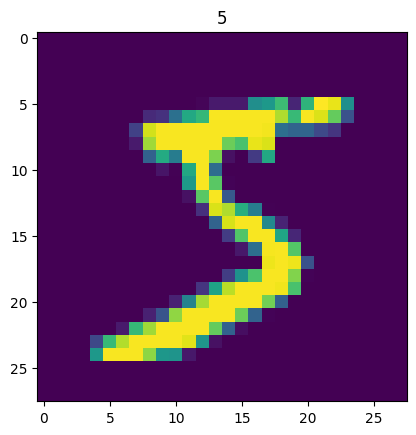

In [23]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")

plt.imshow(image.squeeze())
plt.title(label)

In [24]:
plt.imsave("mnist_sample.png", image.squeeze(), cmap="gray")

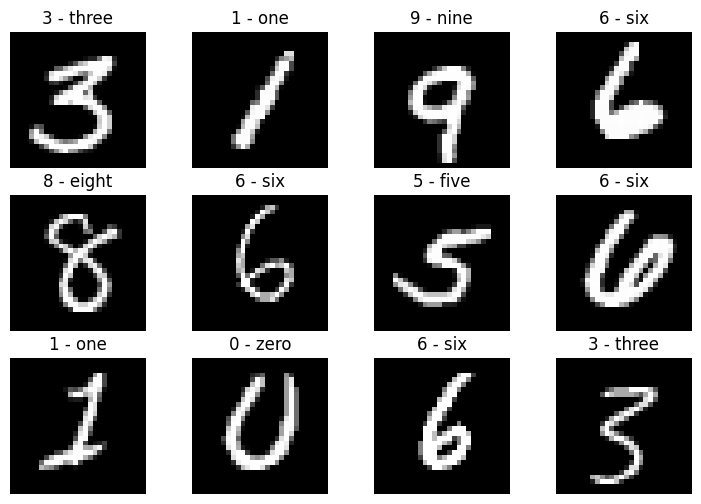

In [25]:
fig = plt.figure(figsize=(9, 6))
rows, cols = 3, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [26]:
train_size = 55_000
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [27]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [28]:
batch_size = 32

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(train_dataset, 256, shuffle=True)
test_dataloader = DataLoader(train_dataset, 256, shuffle=True)

In [30]:
class MNIST_MLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.sequential = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits

In [31]:
model = MNIST_MLP().to(device)
print(model)

MNIST_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [32]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3)

def accuracy_func(logits, y):
    preds = logits.argmax(dim=1)
    correct = (preds == y).sum().item()
    return correct / y.size(0)

In [33]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def eval_model(model: nn.Module, data_laoder: torch.utils.data.DataLoader, loss_func: torch.nn.Module, accuracy_func):
    loss, acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_laoder:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_pred = model(X)
            
            loss += loss_func(test_pred, y)
            acc += accuracy_func(test_pred, y)
            
        loss /= len(data_laoder)
        acc /= len(data_laoder)
        
    return loss.item(), acc

In [35]:
def train_one_epoch(model, loader, optimizer, loss_func, device):
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
    
        logits = model(X)
        loss = loss_func(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_examples += batch_size
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

In [36]:
train_time_start = timer()

epochs = 5
best_val_acc = 0.0

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, loss_func, device)
    val_loss, val_acc = eval_model(model, test_dataloader, loss_func, accuracy_func)
    
    print(f"\nEpoch {epoch:02d} | Train loss: {train_loss:.5f} | Train acc {train_acc:.4f} | Val loss: {val_loss:.5f}, Test acc: {val_acc:.2f}%\n")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # torch.save(model.state_dict(), "mnist_mlp_best.pt")
        print(f"\tSaved new best model with val acc: {best_val_acc:.4f}")
    
train_time_end = timer()
total_train_time = print_train_time(train_time_start, train_time_end, str(next(model.parameters()).device))


  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/55000 samples
Looked at 12800/55000 samples
Looked at 25600/55000 samples
Looked at 38400/55000 samples
Looked at 51200/55000 samples


 20%|██        | 1/5 [00:06<00:24,  6.03s/it]


Epoch 00 | Train loss: 0.29278 | Train acc 0.9134 | Val loss: 0.11982, Test acc: 0.96%

	Saved new best model with val acc: 0.9632
Looked at 0/55000 samples
Looked at 12800/55000 samples
Looked at 25600/55000 samples
Looked at 38400/55000 samples
Looked at 51200/55000 samples


 40%|████      | 2/5 [00:11<00:17,  5.93s/it]


Epoch 01 | Train loss: 0.13176 | Train acc 0.9600 | Val loss: 0.07436, Test acc: 0.98%

	Saved new best model with val acc: 0.9771
Looked at 0/55000 samples
Looked at 12800/55000 samples
Looked at 25600/55000 samples
Looked at 38400/55000 samples
Looked at 51200/55000 samples


 60%|██████    | 3/5 [00:17<00:11,  5.89s/it]


Epoch 02 | Train loss: 0.09680 | Train acc 0.9701 | Val loss: 0.05471, Test acc: 0.98%

	Saved new best model with val acc: 0.9829
Looked at 0/55000 samples
Looked at 12800/55000 samples
Looked at 25600/55000 samples
Looked at 38400/55000 samples
Looked at 51200/55000 samples


 80%|████████  | 4/5 [00:23<00:05,  5.90s/it]


Epoch 03 | Train loss: 0.08094 | Train acc 0.9751 | Val loss: 0.04536, Test acc: 0.99%

	Saved new best model with val acc: 0.9858
Looked at 0/55000 samples
Looked at 12800/55000 samples
Looked at 25600/55000 samples
Looked at 38400/55000 samples
Looked at 51200/55000 samples


100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


Epoch 04 | Train loss: 0.06983 | Train acc 0.9786 | Val loss: 0.02950, Test acc: 0.99%

	Saved new best model with val acc: 0.9907
Train time on mps:0: 29.564 seconds


In [37]:
loss_results, acc_results = eval_model(model, test_dataloader, loss_func, accuracy_func)
loss_results, acc_results

(0.02948669157922268, 0.9907488156761413)